In [3]:
## Import needed libraries
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import pylab   as plt

In [4]:
# hSBM specific libraries
from sbmtm import sbmtm
import graph_tool.all as gt

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
file = open('hSBM_simple_model.pickle', 'rb')
model = pickle.load(file)

In [7]:
# The hierarchical levels themselves are represented by individual BlockState() instances
levels = model.state.get_levels()
for s in levels:
    print(s)
    if s.get_N() == 1:
        break

<BlockState object with 38423 blocks (2 nonempty), degree-corrected, for graph <Graph object, undirected, with 38423 vertices and 46181 edges, 2 internal vertex properties, at 0x7f0b0925a450>, at 0x7f0b72962a10>
<BlockState object with 2 blocks (1 nonempty), for graph <Graph object, undirected, with 38423 vertices and 1 edge, at 0x7f0af6e657d0>, at 0x7f0b624456d0>


In [8]:
nest_state = model.state
lstate = nest_state.get_levels()[0]
adj_matrix = gt.adjacency(g=lstate.get_bg(),weight=lstate.get_ers()).T
synth_graph = gt.generate_sbm(b=lstate.b.a, probs=adj_matrix, 
                            out_degs=lstate.g.degree_property_map("total").a,
                            in_degs=lstate.g.degree_property_map("total").a,
                            directed=False)
synth_nest_state = model.state.copy(g=synth_graph)

In [9]:
synth_file = open('synth_hSBM_simple_model.pickle', 'rb')
synth_model = pickle.load(synth_file)

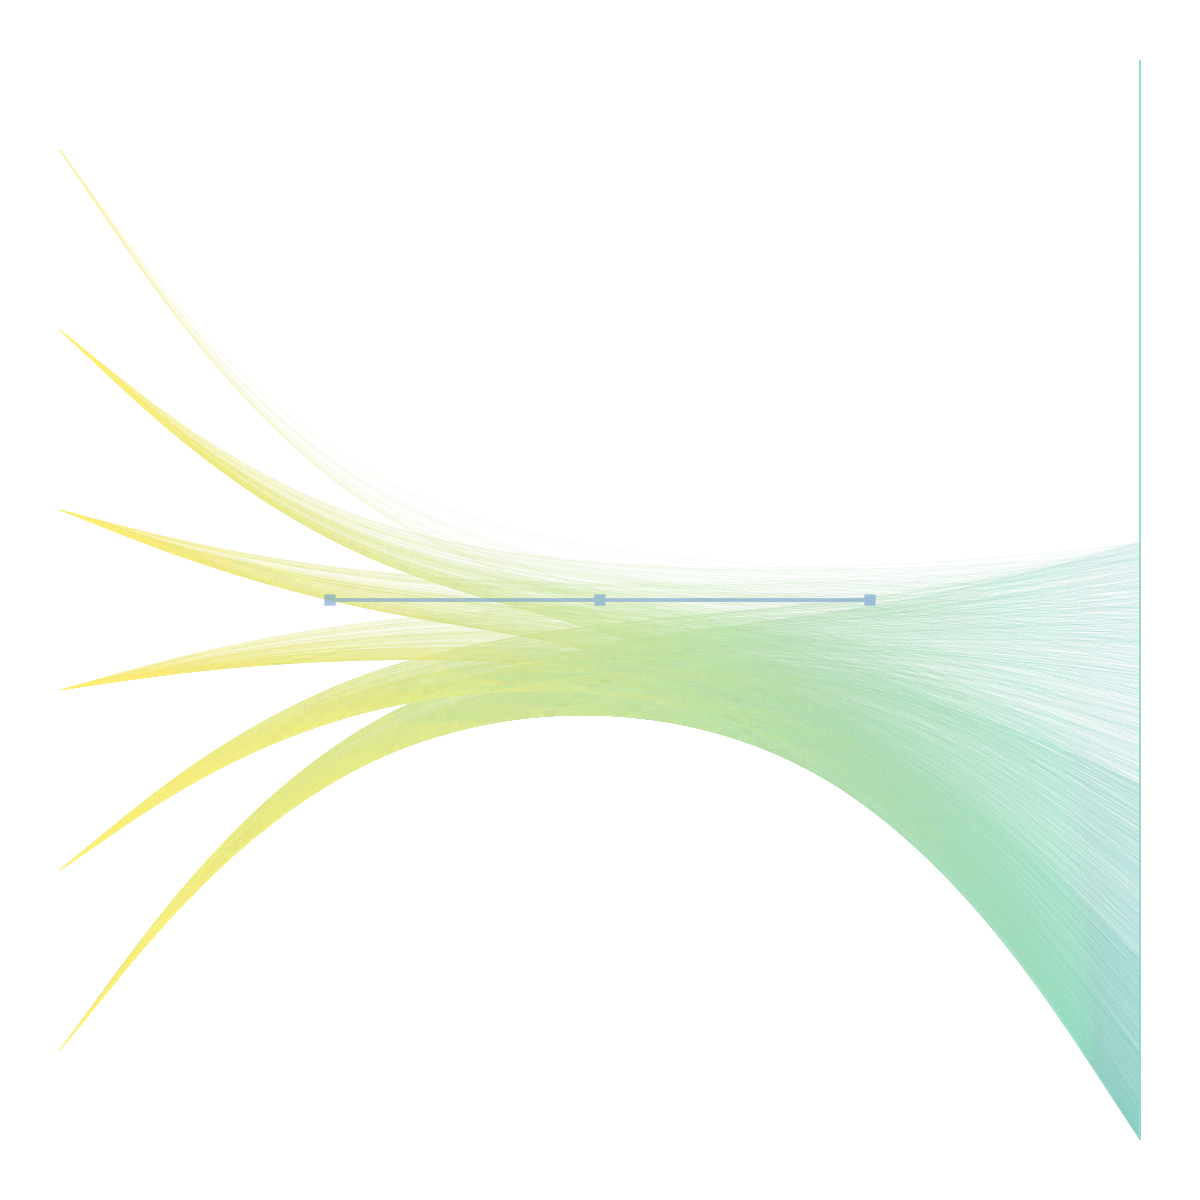

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0b106c4b50, at 0x7f0af6e57f90>,
 <GraphView object, directed, with 38426 vertices and 38425 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f0b624abc50, at 0x7f0b62464a10>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f0b624abc50, at 0x7f0b624abd10>, False), at 0x7f0b624abc50>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0b624abc50, at 0x7f0af7cb0b50>)

In [10]:
synth_model.draw(subsample_edges=6000,layout='bipartite',bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [48]:
def index_array(which_model,clabel):
    array = [i for i in range(len(which_model.get_clabel(l=0).a)) if which_model.get_clabel(l=0).a[i] == clabel]
    return array

In [38]:
words_index = index_array(which_model=synth_model, clabel=1)
documents_index = index_array(which_model=synth_model, clabel=0)

synth_df = pd.DataFrame(data=0, index=documents_index, columns=words_index)

for document in documents_index:
    neighbors = nest_state.g.get_all_neighbors(document)
    if neighbors.size == 0:
        continue
    else:
        for col in synth_df.columns:
            if col in neighbors:
                synth_df[col][document] = 1

synth_df

,38417,38418,38419,38420,38421,38422
0,1,1,0,0,0,0
1,0,1,1,0,0,0
2,0,0,0,1,0,0
3,0,1,0,0,0,0
4,0,1,0,1,0,0
...,...,...,...,...,...,...
38412,0,0,0,0,0,0
38413,0,0,0,1,1,0
38414,0,0,0,0,1,0
38415,0,1,0,1,0,0


In [13]:
state = model.state
state_0 = state.get_levels()[0]
matrix = gt.adjacency(g=state_0.get_bg(),weight=state_0.get_ers()).T
graph = gt.generate_sbm(b=state_0.b.a, probs=matrix, 
                            out_degs=state_0.g.degree_property_map("total").a,
                            in_degs=state_0.g.degree_property_map("total").a,
                            directed=False)
new_state = gt.minimize_nested_blockmodel_dl(graph,
                                             state_args=dict(base_type=gt.BlockState, **{'clabel': state_0.g.vp['kind'], 'pclabel': state_0.g.vp['kind']}),
                                             multilevel_mcmc_args=dict(verbose=False))

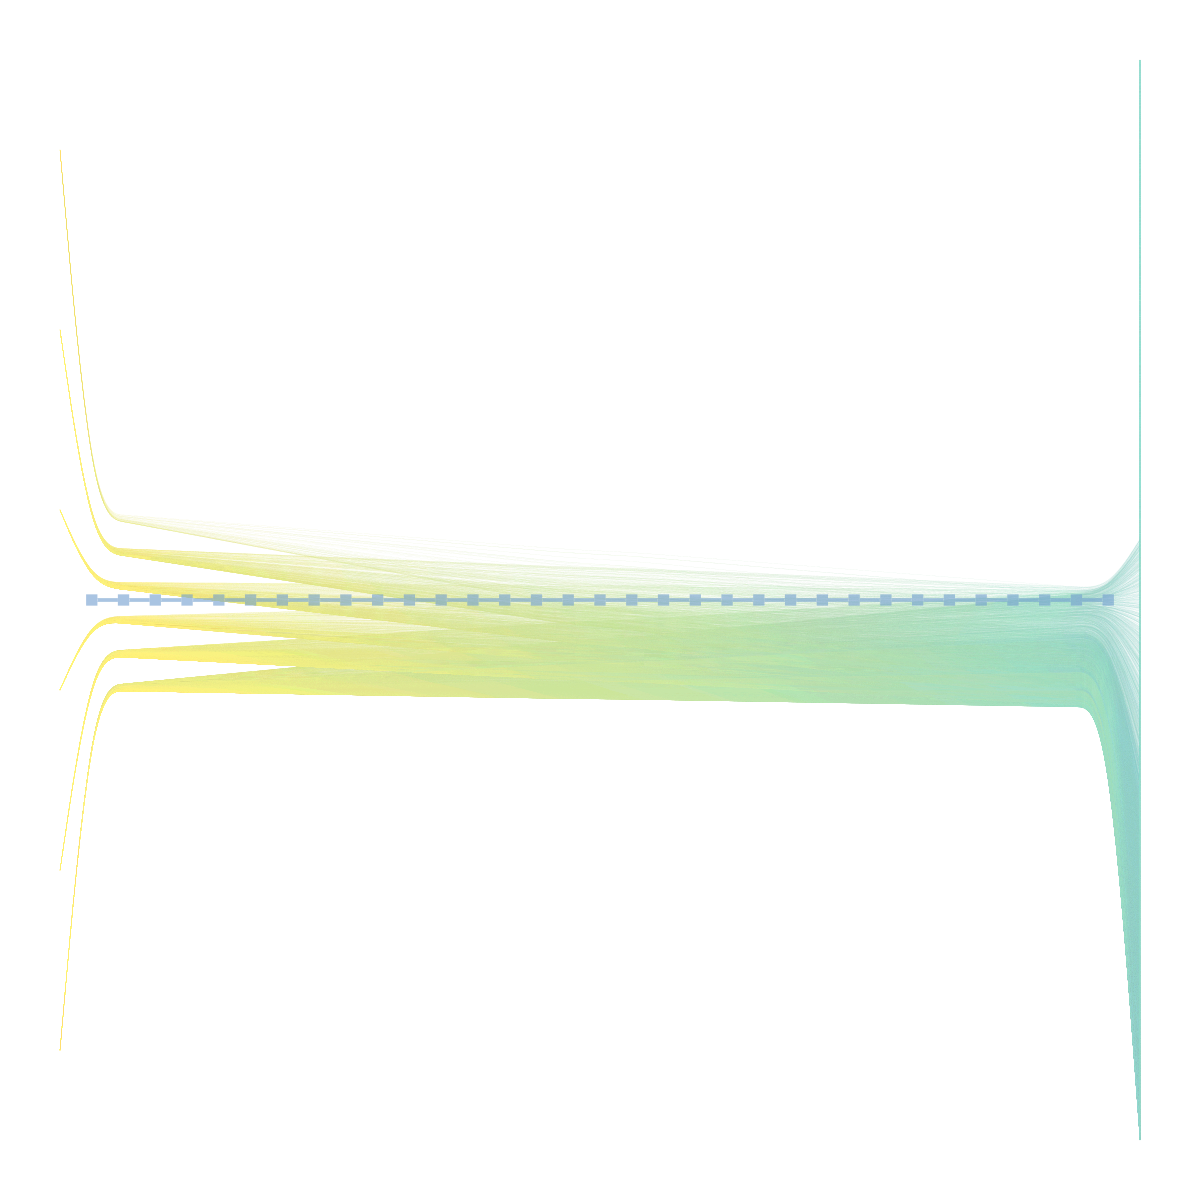

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0b62464050, at 0x7f0b4923c550>,
 <GraphView object, directed, with 38456 vertices and 38455 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f0b491339d0, at 0x7f0b72883090>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f0b491339d0, at 0x7f0b72883bd0>, False), at 0x7f0b491339d0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0b491339d0, at 0x7f0b728c34d0>)

In [34]:
new_state.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [20]:
for i_n_init in range(10):
    base_type = gt.BlockState
    state_tmp = gt.minimize_nested_blockmodel_dl(graph,
                                                state_args=dict(
                                                    base_type=base_type,
                                                    **{'clabel': state_0.g.vp['kind'], 'pclabel': state_0.g.vp['kind']}),
                                                multilevel_mcmc_args=dict(
                                                    verbose=False))
    L = 0
    for s in state_tmp.levels:
        L += 1
        if s.get_nonempty_B() == 2:
            break
    state_tmp = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])

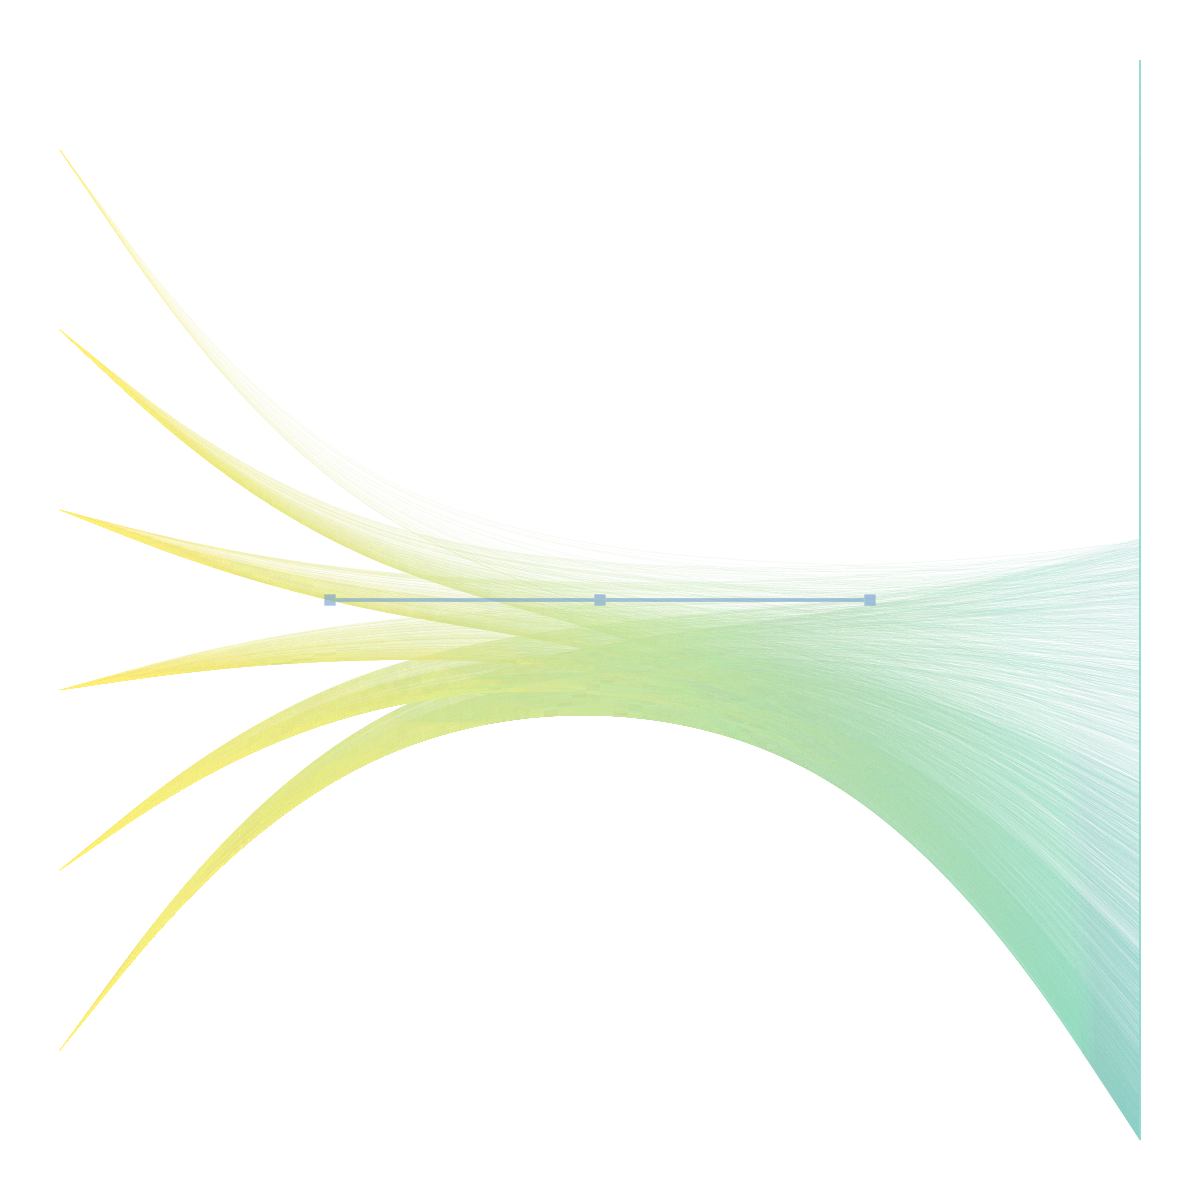

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0b62464050, at 0x7f0b72874150>,
 <GraphView object, directed, with 38426 vertices and 38425 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f0b72880250, at 0x7f0b72869290>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f0b72880250, at 0x7f0b72869f10>, False), at 0x7f0b72880250>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f0b72880250, at 0x7f0b72871310>)

In [26]:
state_tmp.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [57]:
features_index = index_array(which_model=state_tmp, clabel=1)
patients_index = index_array(which_model=state_tmp, clabel=0)

df = pd.DataFrame(data=0, index=patients_index, columns=features_index)

for patient in patients_index:
    neighbors = state_tmp.g.get_all_neighbors(patient)
    if neighbors.size == 0:
        continue
    else:
        for col in df.columns:
            if col in neighbors:
                df[col][patient] = 1

df

In [56]:
state_tmp.g.get_all_neighbors(66)

PropertyArray([0, 0, 0, ..., 1, 1, 1], dtype=int32)